In [2]:
import torch
from loguru import logger
from tqdm import tqdm
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

import mdtraj as md
import nglview as nv

from rocketshp import config
from rocketshp.plot import display_trajectory
from rocketshp.dataset import ATLASDataModule
from rocketshp.modeling.architectures import FlexibilityModel

2024-11-26 14:59:04.602 | INFO     | rocketshp.config:<module>:13 - PROJ_ROOT path is: /mnt/home/ssledzieski/Projects/rocketshp
/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
config_file = "../configs/config.yml"
# checkpoint_file = fmnew = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split/model-epoch=14-train_loss=0.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=02-train_loss=2.68.pt.ckpt"
checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=07-train_loss=2.66.pt.ckpt"

PARAMS = config.DEFAULT_PARAMETERS
PARAMS.update(OmegaConf.load(config_file))


In [4]:
adl = ATLASDataModule(config.PROCESSED_DATA_DIR / "atlas/atlas_processed.h5",
                      seq_features=True, struct_features=True,
                      batch_size=8, num_workers=PARAMS.num_data_workers,
                      train_pct=PARAMS.train_pct, val_pct=PARAMS.val_pct,
                      random_seed=PARAMS.random_seed,
                      )
adl.setup("train")
ads = adl.dataset
logger.info(f"{len(adl.dataset)}, {len(adl.train_data)}, {len(adl.val_data)}, {len(adl.test_data)}")

2024-11-26 14:59:12.273 | INFO     | __main__:<module>:9 - 4167, 3360, 396, 411


In [5]:
model = FlexibilityModel.load_from_checkpoint(checkpoint_file, strict=False)

/mnt/home/ssledzieski/Projects/rocketshp/rocketshp/modeling/architectures.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(checkpoint_path)


2024-11-26 15:00:42.510 | INFO     | __main__:<module>:31 - Protein: 2x5g_A/R1
2024-11-26 15:00:42.511 | INFO     | __main__:<module>:32 - Spearman: SignificanceResult(statistic=0.7669153553988062, pvalue=8.291682422652276e-20)
2024-11-26 15:00:42.512 | INFO     | __main__:<module>:33 - Pearson: PearsonRResult(statistic=0.8039271391419334, pvalue=6.201212e-23)
2024-11-26 15:00:42.512 | INFO     | __main__:<module>:34 - MSE: 0.011170071549713612


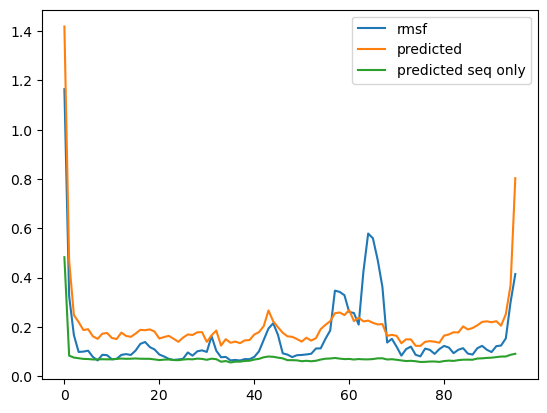

In [19]:
SAMPLE_I = 180

def normalize(x):
    return (x - x.mean()) / x.std()

feats, labels = adl.test_data[SAMPLE_I]
key = adl.dataset.samples[adl.test_data.indices[SAMPLE_I]]
with torch.no_grad():
        both_result = model((feats["seq_feats"].unsqueeze(0), feats["struct_feats"].unsqueeze(0)))
        seqonly_result = model((feats["seq_feats"].unsqueeze(0), torch.zeros_like(feats["struct_feats"]).unsqueeze(0)))

        yhat_both = both_result["rmsf"]
        sqfm_both = both_result["ca_dist"]
        
        yhat_seqonly = seqonly_result["rmsf"]
        sqfm_seqonly = seqonly_result["ca_dist"]

bf_both = yhat_both.detach().cpu().numpy().squeeze()
bf_seqonly = yhat_seqonly.detach().cpu().numpy().squeeze()

plt.plot(labels["rmsf"],label="rmsf")
plt.plot(bf_both,label="predicted")
plt.plot(bf_seqonly,label="predicted seq only")
plt.legend()


from scipy.stats import spearmanr, pearsonr
spearman = spearmanr(labels["rmsf"], bf_both)
pearson = pearsonr(labels["rmsf"], bf_both)
mse = ((labels["rmsf"] - bf_both)**2).mean()
logger.info(f"Protein: {key}")
logger.info(f"Spearman: {spearman}")
logger.info(f"Pearson: {pearson}")
logger.info(f"MSE: {mse}")

plt.show()

In [7]:
pdb_code, rep = key.split("/")
traj = md.load_xtc(config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc", top=config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}.pdb")
view = display_trajectory(traj, bfactor=bf_both, coloring="bfactor", normalize=True, RMAX=0.5)
view

NGLWidget(max_frame=10000)

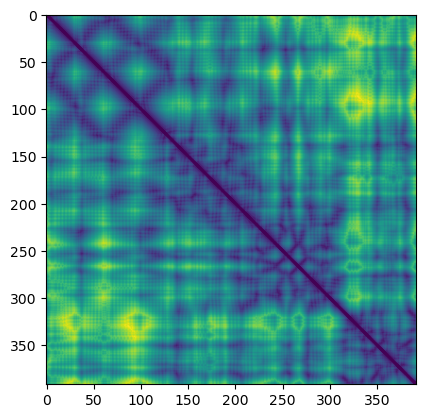

In [8]:
sqform = md.geometry.squareform(
                *md.compute_contacts(traj[0], scheme="ca", ignore_nonprotein=True)
            )
plt.imshow(sqform.squeeze())
plt.show()

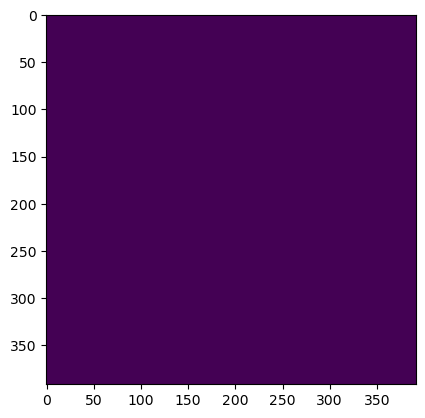

In [37]:
plt.imshow(sqfm_both.squeeze())
plt.show()

In [38]:
fb, yb, lb = next(iter(adl.train_dataloader()))

In [39]:
predb = model((fb["seq_feats"], fb["struct_feats"]))

In [40]:
predb["ca_dist"].shape,yb["ca_dist"].shape,predb["rmsf"].shape,yb["rmsf"].shape

(torch.Size([8, 415, 415]),
 torch.Size([8, 415, 415]),
 torch.Size([8, 415, 1]),
 torch.Size([8, 415]))

In [41]:
from rocketshp.modeling.pt_lightning import compute_square_masked_mse_loss, compute_masked_mse_loss

In [42]:
compute_masked_mse_loss(predb["rmsf"], yb["rmsf"].unsqueeze(-1), lb, rmse=True)

tensor(0.0748, grad_fn=<SqrtBackward0>)

In [43]:
compute_square_masked_mse_loss(predb["ca_dist"], yb["ca_dist"], lb, rmse=True)

tensor(3.0609, grad_fn=<SqrtBackward0>)

In [44]:
x = model._transform((fb["seq_feats"], fb["struct_feats"]))

In [46]:
sqform_tensor = model.squareformer((x.unsqueeze(1) * x.unsqueeze(2)).transpose(1,3)).squeeze()

In [49]:
sqform_tensor.shape, predb["ca_dist"].shape

(torch.Size([8, 415, 415]), torch.Size([8, 415, 415]))